In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from h2m_translation.taxonomy_normalizer import NaiveTaxonomyNormalizer, preprocess_filter_rare_taxa_relative_abundance


Load data from Haddad OSA experiment:

In [2]:
taxa = pd.read_csv('data/taxonomic_observed_abundance_HaddadOSA.csv').set_index('#SampleID')

metadata = pd.read_csv('data/relevant_metadata_haddad_osa.csv').set_index('#SampleID')

metabolite_features = pd.read_csv('data/metabolite_unique_gnp_annotated_HaddadOSA.csv').set_index('sample_id')

filter only the control samples from both the metabolite and the taxonomy using the metadata:


In [3]:
control_samples = metadata[metadata.control].index
metabolite_features = metabolite_features.loc[control_samples, :]
taxa = taxa.loc[control_samples, :]

Prep taxa: calculate relative-abundance, consider if to drop unknown or not


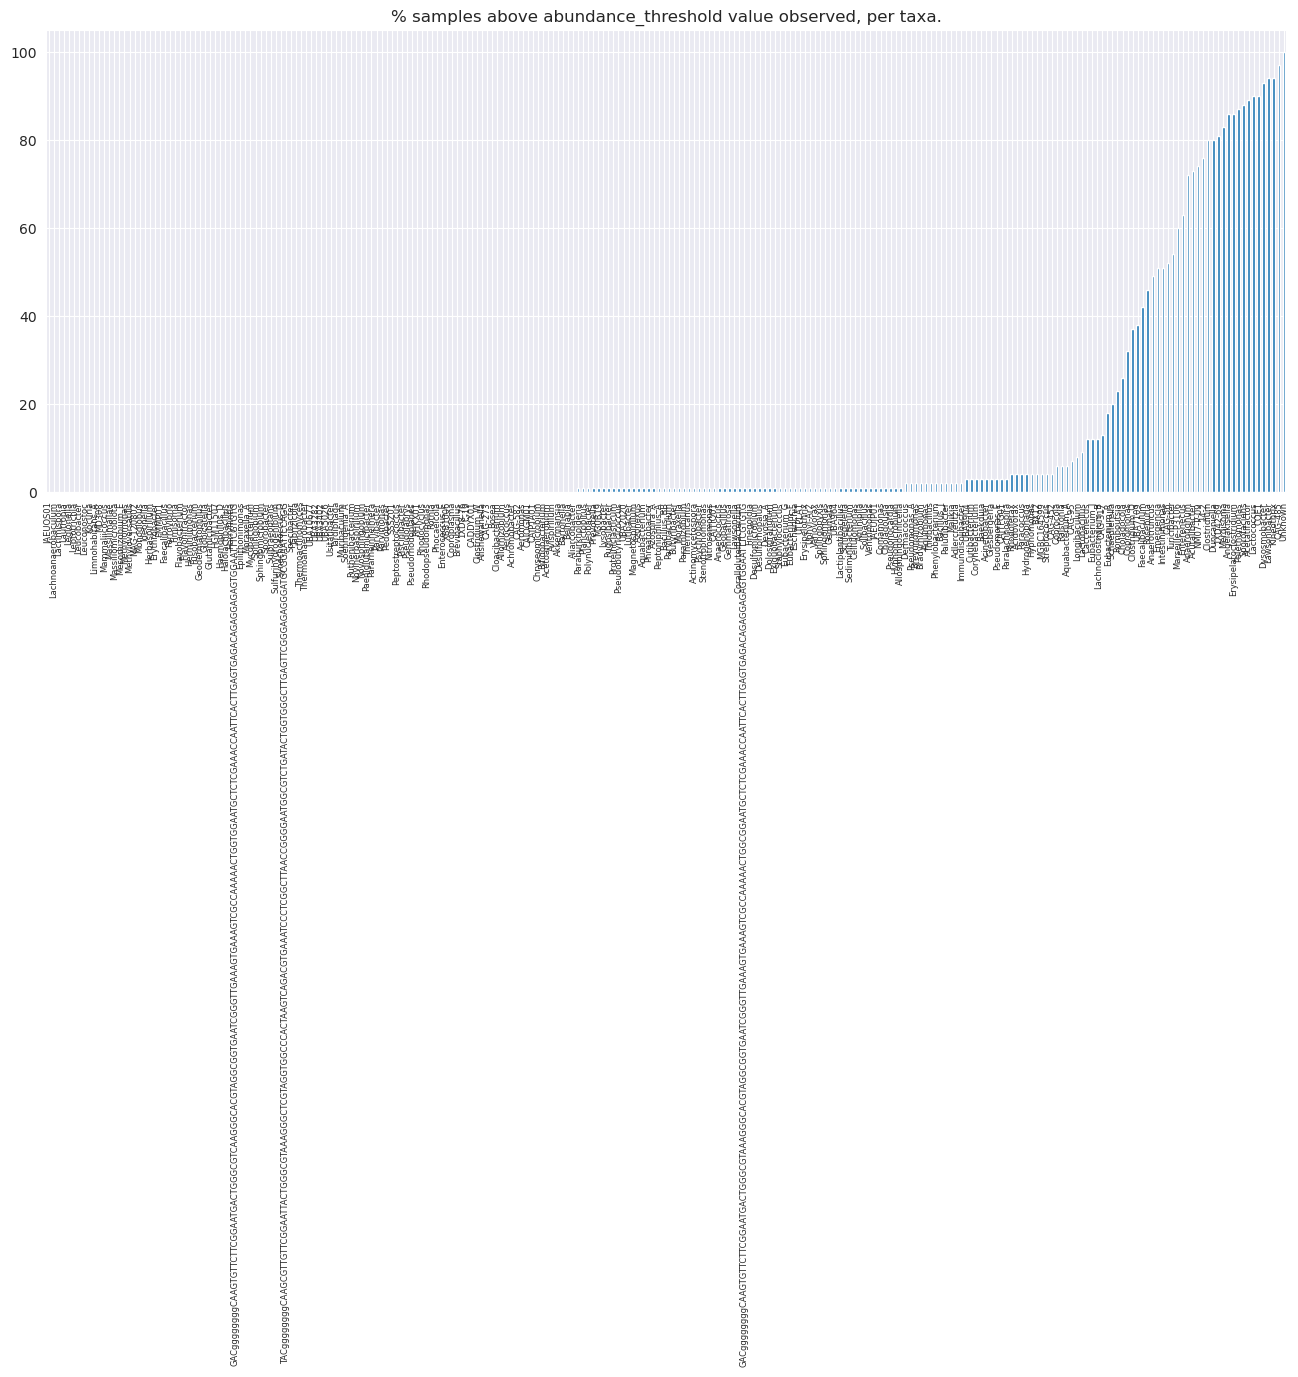

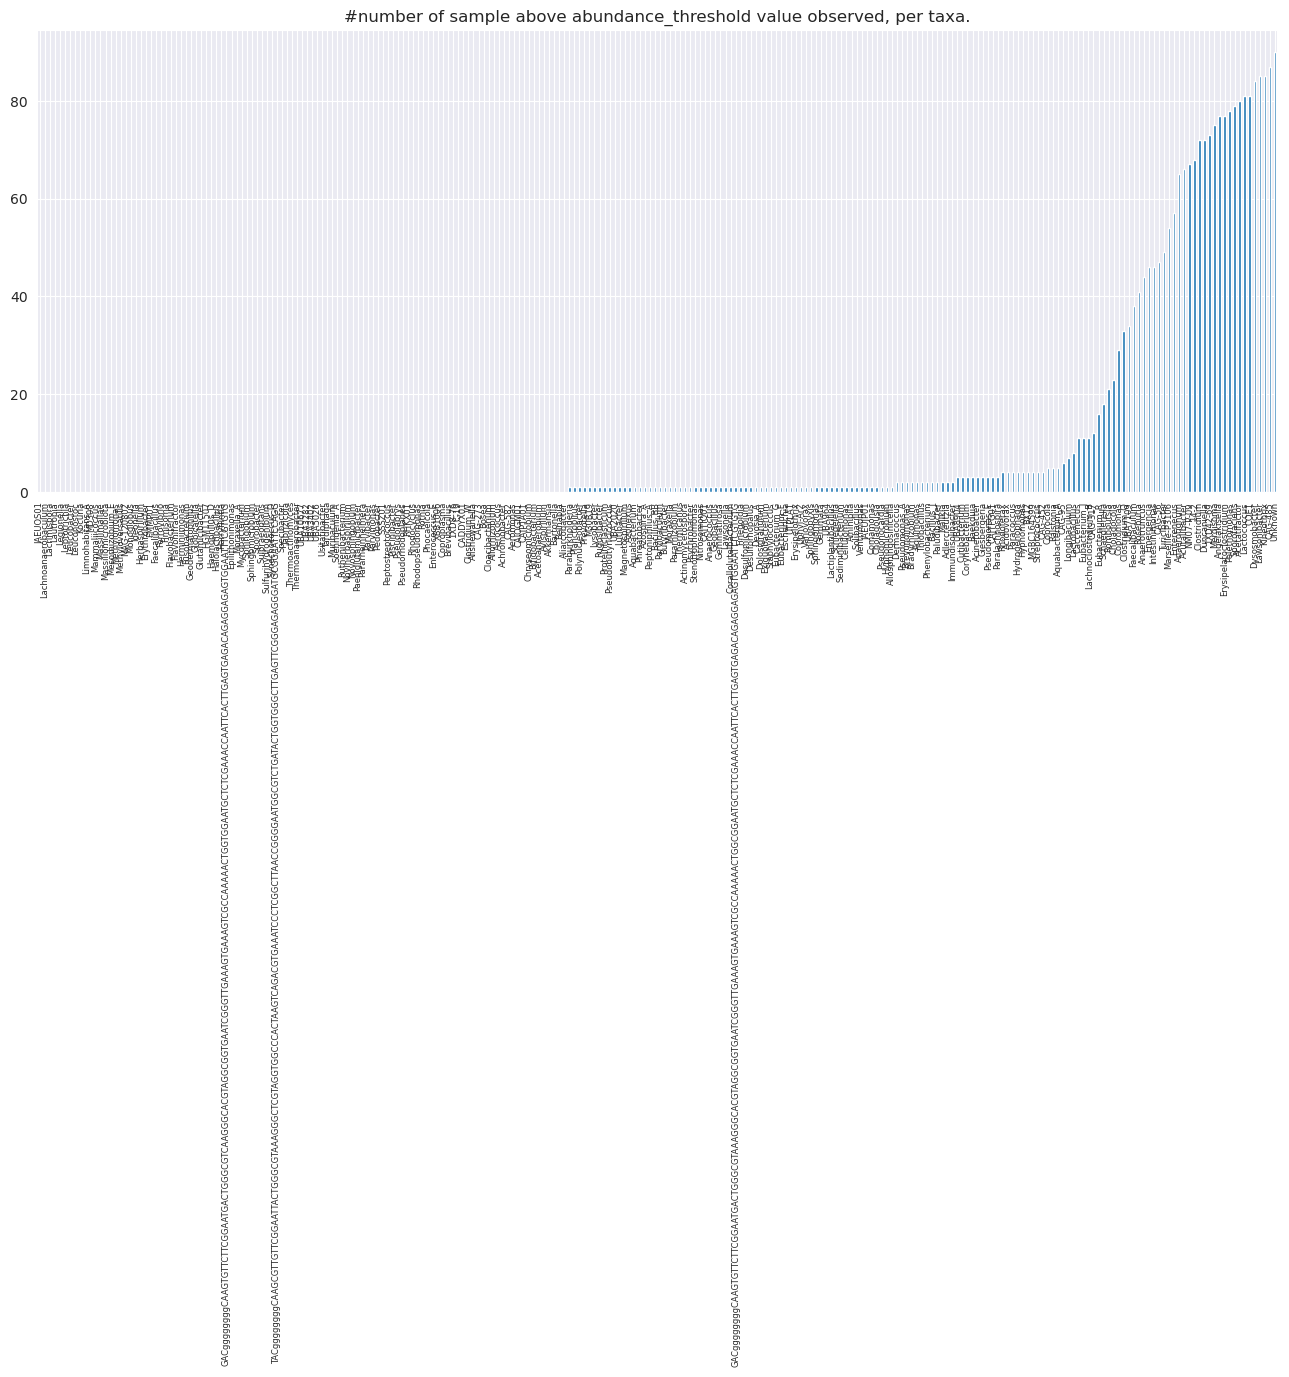

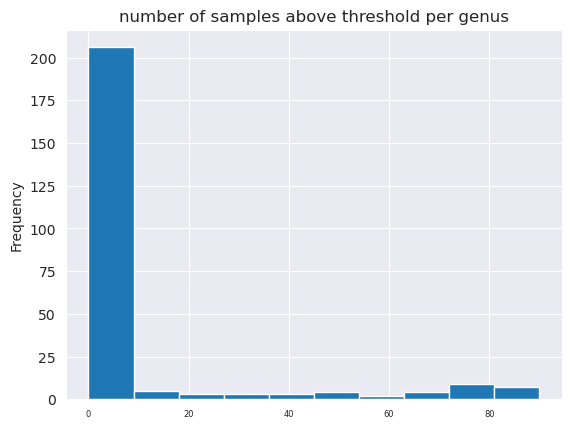

The number of genus/features that have non-zero values on > 10 % samples are: 40 out of 246 genus/features before-filtering.


In [4]:
DROP_UNKNOWN_TAXA = False
UNKNOWN_TH = 1.0
naive_normalizer = NaiveTaxonomyNormalizer(drop_unknown_taxa=DROP_UNKNOWN_TAXA, unknown_taxa_sample_threshold=UNKNOWN_TH)
relative_abundance = naive_normalizer.normalize(taxa)
relative_abundance = preprocess_filter_rare_taxa_relative_abundance(relative_abundance,  verbose=True, percentage=10, abundance_threshold=0.001)


Prep metabolite:

Are there nan values: False. Filling any nans with zeros.


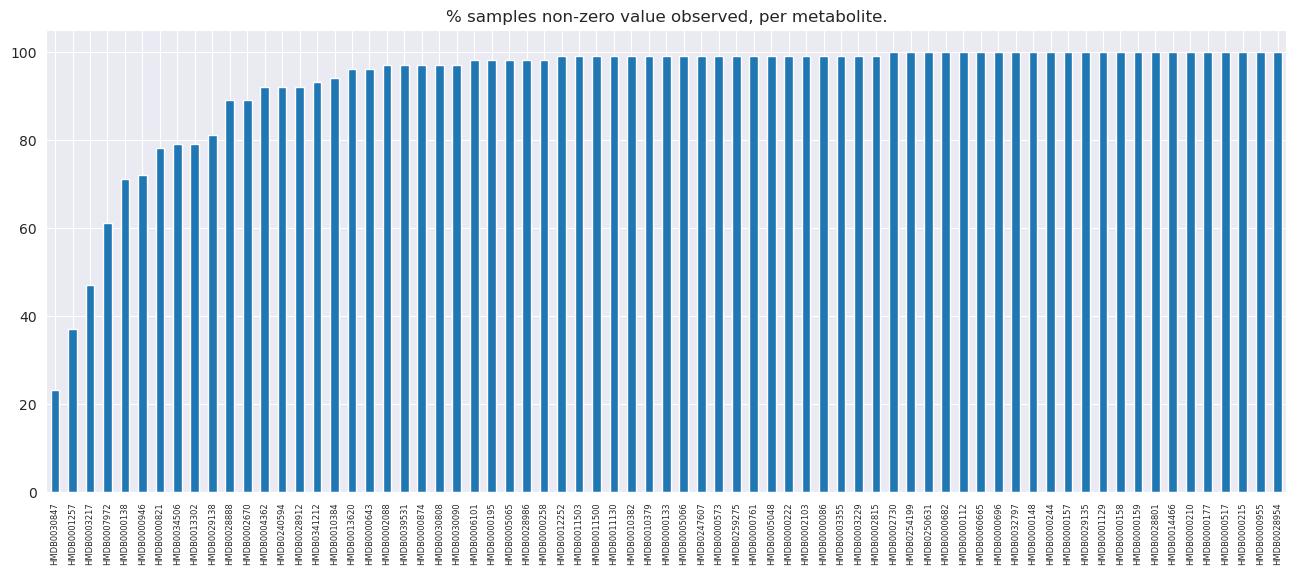

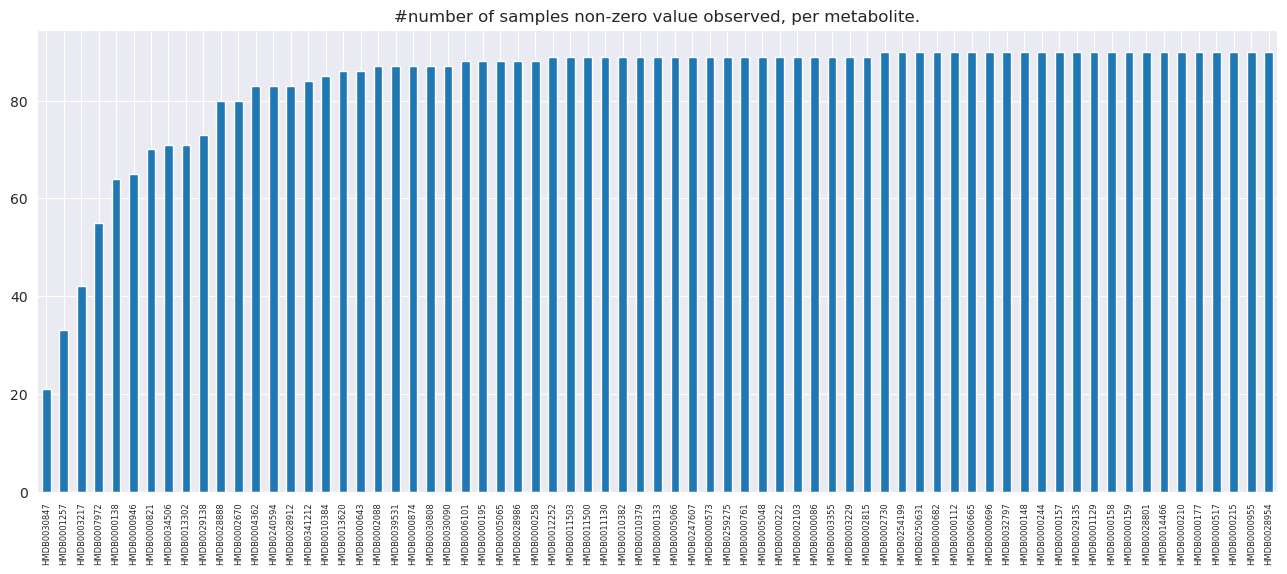

There are 61 metabolite with sufficient number of samples (>85%) out of 71 metabolites.


/home/noa/lab_code/H2Mtranslation/h2m_translation/preprocessors.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metabolite_features.replace(to_replace=np.nan, value=0, inplace=True)
/home/noa/lab_code/H2Mtranslation/h2m_translation/preprocessors.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metabolite_features.replace(to_replace=0, value=min_value_per_metabolite, inplace=True)


In [5]:
from preprocessors import MetabolitePreprocessor
metabolite_preprocessor = MetabolitePreprocessor()
metabolite_features = metabolite_preprocessor.preprocess(metabolite_features)


Correlation test:
For each metabolite independently, and for each taxa independently, (aka for each (metabolite, genus) tuple) calculate correlation across samples. 

In [6]:
metabolome_bacteria_corr_coefficient = pd.DataFrame(index=relative_abundance.columns, columns=metabolite_features.columns)
metabolome_bacteria_p_values = pd.DataFrame(index=relative_abundance.columns, columns=metabolite_features.columns)

for metabolome in metabolite_features.columns:
    for bacteria in relative_abundance.columns:
        coefficient, p  = stats.kendalltau(metabolite_features[metabolome], relative_abundance[bacteria])
        metabolome_bacteria_corr_coefficient.loc[bacteria, metabolome] = coefficient
        metabolome_bacteria_p_values.loc[bacteria, metabolome] = p
        
# Dropping the "Unknown"
metabolome_bacteria_corr_coefficient = metabolome_bacteria_corr_coefficient.drop(index=['Unknown'])
metabolome_bacteria_p_values = metabolome_bacteria_p_values.drop(index=['Unknown'])

In [8]:
# With multi-comparison correction (FDR)
from statsmodels.stats.multitest import fdrcorrection
# what to do with nans?
p_values = metabolome_bacteria_p_values.stack()
_, p_values_corrected = fdrcorrection(p_values)
metabolome_bacteria_p_values_fdr_correction = pd.Series(p_values_corrected, index=p_values.index).unstack()

In [14]:
metabolome_bacteria_corr_coefficient = metabolome_bacteria_corr_coefficient.T.stack()
metabolome_bacteria_p_values_fdr_correction = metabolome_bacteria_p_values_fdr_correction.T.stack()
metabolome_bacteria_significant_corr = metabolome_bacteria_corr_coefficient[metabolome_bacteria_p_values_fdr_correction < 0.05]

In [21]:
print(f"{metabolome_bacteria_significant_corr.shape[0]} couples are significant out of {metabolome_bacteria_p_values_fdr_correction.shape[0]} aka {round(100 * metabolome_bacteria_significant_corr.shape[0]/metabolome_bacteria_p_values_fdr_correction.shape[0], 2)} %")

253 couples are significant out of 2379 aka 10.63 %


In [23]:
metabolome_bacteria_significant_corr.to_pickle(f'analysis/metabolome_bacteria_significant_corr_kendall-tau.pkl')
metabolome_bacteria_corr_coefficient.to_pickle(f'analysis/metabolome_bacteria_corr_coefficient_kendall-tau.pkl')
metabolome_bacteria_p_values_fdr_correction.to_pickle(f'analysis/metabolome_bacteria_p_values_fdr_correction_kendall-tau.pkl')

Analysis

In [22]:
metabolome_bacteria_significant_corr.sort_values(ascending=False)


Palmitoleic acid  Faecalibaculum     0.447431
HMDB0247607       Faecalibaculum     0.399269
HMDB0005048       Faecalibaculum     0.389755
Elaidic acid      Faecalibaculum     0.384999
HMDB0030808       CAG-317            0.366843
                                       ...   
Palmitoleic acid  CAG-485           -0.360726
HMDB0039531       Faecalibaculum    -0.366406
L-Arginine        NM07-P-09         -0.394018
HMDB0060665       Marseille-P3106   -0.402336
                  Lactococcus       -0.404496
Length: 253, dtype: object

In [29]:
print(f"Out of {metabolite_features.shape[1]} metabolites tested {len(metabolome_bacteria_significant_corr.index.get_level_values(0).unique())} had any significant correlation with some bacteria")

Out of 61 metabolites tested 53 had any significant correlation with some bacteria


In [24]:
# Number of bacteria each metabolites significantly associate with
metabolome_bacteria_significant_corr.groupby(axis=0, level=0).apply(lambda x: x.shape[0]).sort_values(ascending=False).describe()

count    53.000000
mean      4.773585
std       3.244175
min       1.000000
25%       2.000000
50%       4.000000
75%       7.000000
max      12.000000
dtype: float64

In [30]:
# Number of metabolites each bacteria significantly associate with
metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).describe()

count    36.000000
mean      7.027778
std       5.808792
min       1.000000
25%       2.750000
50%       5.000000
75%      10.250000
max      24.000000
dtype: float64

<Axes: title={'center': 'Lactococcus significant correlation to metabolites'}>

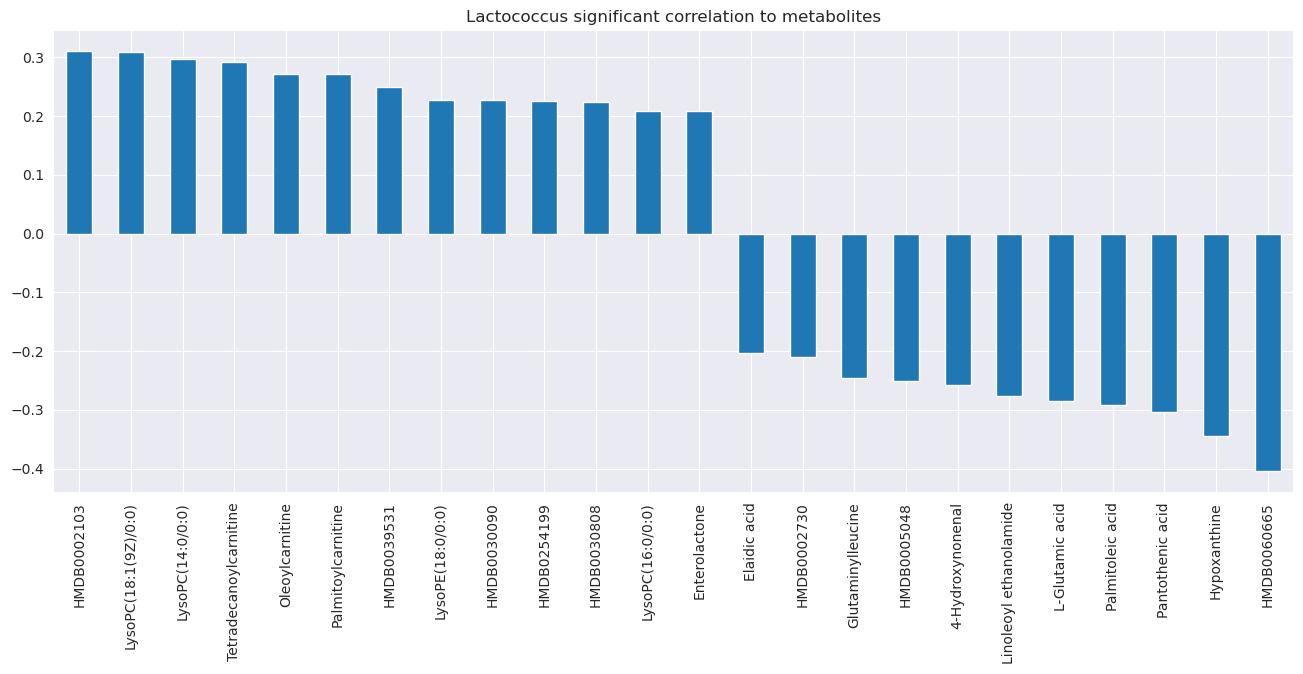

In [31]:
import matplotlib.pyplot as plt

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
idx = pd.IndexSlice

top_bacteria = metabolome_bacteria_significant_corr.groupby(axis=0, level=1).apply(lambda x: x.shape[0]).idxmax()
metabolome_bacteria_significant_corr.loc[idx[:, top_bacteria]].sort_values(ascending=False).plot.bar(figsize=(16,6), title=f'{top_bacteria} significant correlation to metabolites')

Indeed we got that Lactococcus is significantly effecting on many metabolites. And this genus is a lactic acid bacteria that known to produce a single product - lactic acid. 

[Text(0.5, 1.0, 'Heatmap significant correlation of Metabolite & Bacteria')]

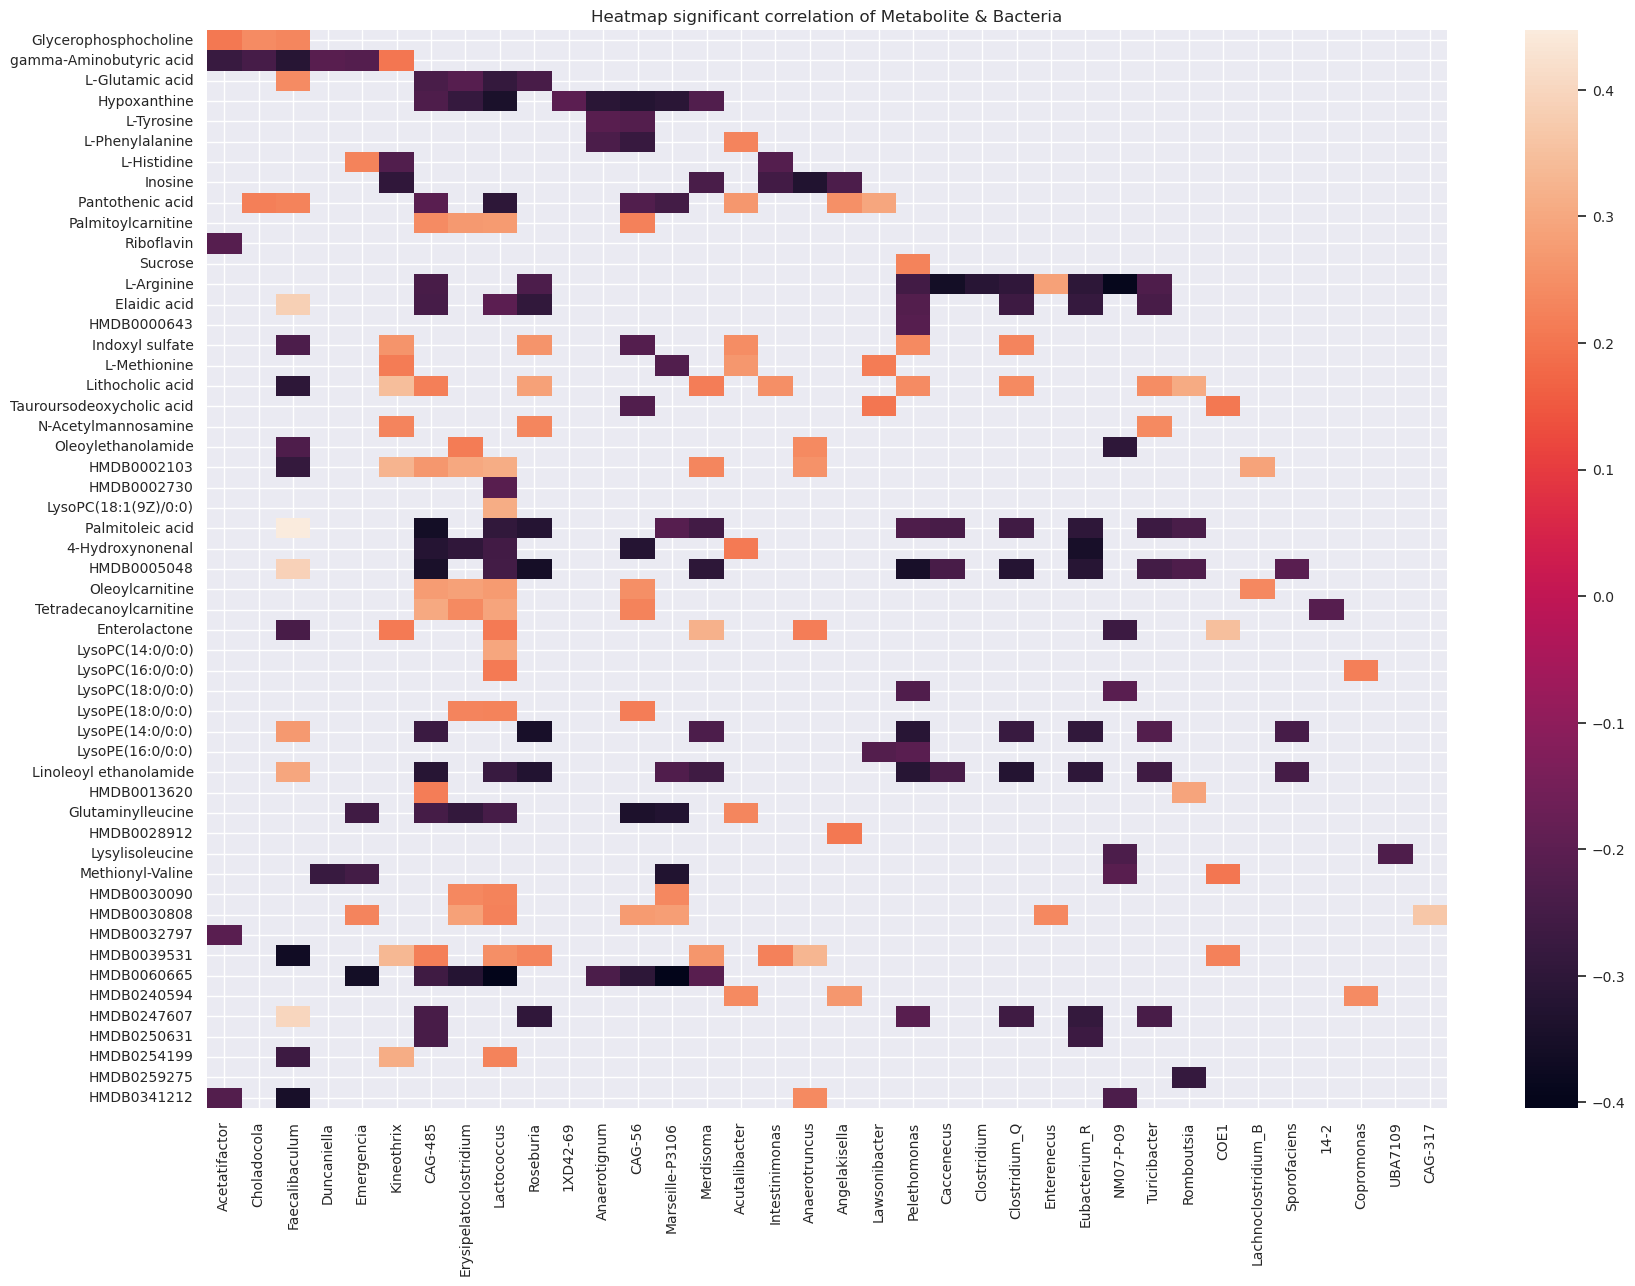

In [34]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(20,14), 'xtick.labelsize':10, 'ytick.labelsize':10})
sns.heatmap(metabolome_bacteria_significant_corr.unstack().astype(float)).set(title='Heatmap significant correlation of Metabolite & Bacteria')
